In [29]:
!pip install arch

   ---------------------------------------- 0.0/928.2 kB ? eta -:--:--
   ---------------------------------------- 10.2/928.2 kB ? eta -:--:--
   - ------------------------------------- 41.0/928.2 kB 495.5 kB/s eta 0:00:02
   --- ----------------------------------- 92.2/928.2 kB 880.9 kB/s eta 0:00:01
   ------ ------------------------------- 163.8/928.2 kB 984.6 kB/s eta 0:00:01
   -------- ----------------------------- 204.8/928.2 kB 958.4 kB/s eta 0:00:01
   ---------- --------------------------- 256.0/928.2 kB 983.0 kB/s eta 0:00:01
   ------------- -------------------------- 307.2/928.2 kB 1.0 MB/s eta 0:00:01
   --------------- ------------------------ 358.4/928.2 kB 1.0 MB/s eta 0:00:01
   ------------------ --------------------- 419.8/928.2 kB 1.1 MB/s eta 0:00:01
   ------------------- -------------------- 450.6/928.2 kB 1.0 MB/s eta 0:00:01
   ---------------------- ----------------- 522.2/928.2 kB 1.1 MB/s eta 0:00:01
   ----------------------- ---------------- 553.0/928.2 k

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import acf

In [3]:

def create_commodity_price_dataframe():
    # List of files to read
    file_names = [
        'E:/Acads(Official)/SEM 6/Prosperity/Round 1/round-1-island-data-bottle/prices_round_1_day_0.csv',
        'E:/Acads(Official)/SEM 6/Prosperity/Round 1/round-1-island-data-bottle/prices_round_1_day_1.csv', 
        'E:/Acads(Official)/SEM 6/Prosperity/Round 1/round-1-island-data-bottle/prices_round_1_day_2.csv'
    ]
    
    # List to store individual dataframes
    dataframes = []
    
    # Read each file
    for file_name in file_names:
        try:
            # Check if file exists
            if not os.path.exists(file_name):
                print(f"Warning: File '{file_name}' not found.")
                continue
                
            # Read the CSV file with semicolon separator
            df = pd.read_csv(
                file_name,
                sep=';',
                na_values=[''],  # Empty fields become NaN
                keep_default_na=True
            )
            
            # Add to our list of dataframes
            dataframes.append(df)
            print(f"Successfully read '{file_name}' with {len(df)} rows.")
            
        except Exception as e:
            print(f"Error reading '{file_name}': {str(e)}")
    
    # If no data was read, return empty DataFrame
    if not dataframes:
        print("No data was read from any files.")
        return pd.DataFrame()
    
    # Combine all dataframes
    combined_df = pd.concat(dataframes, ignore_index=True)
    
    # Convert numeric columns to appropriate types
    numeric_columns = [
        'day', 'timestamp',
        'bid_price_1', 'bid_volume_1', 'bid_price_2', 'bid_volume_2', 
        'bid_price_3', 'bid_volume_3', 'ask_price_1', 'ask_volume_1', 
        'ask_price_2', 'ask_volume_2', 'ask_price_3', 'ask_volume_3', 
        'mid_price', 'profit_and_loss'
    ]
    
    for col in numeric_columns:
        if col in combined_df.columns:
            combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')
    
    return combined_df

# Run the program
if __name__ == "__main__":
    # Create the combined dataframe
    price_df = create_commodity_price_dataframe()
    
    if not price_df.empty:
        print("\nCombined DataFrame created successfully!")
        print(f"Total rows: {len(price_df)}")
        print(f"Columns: {', '.join(price_df.columns)}")
        
        # Optional: Product summary
        print("\nProducts in the dataset:")
        print(price_df['product'].value_counts())
        
        # Optional: Save combined data to a new file
        # price_df.to_csv('combined_prices.csv', index=False)
        # print("\nData saved to 'combined_prices.csv'")
    else:
        print("Failed to create combined DataFrame.")

print(price_df)

Successfully read 'E:/Acads(Official)/SEM 6/Prosperity/Round 1/round-1-island-data-bottle/prices_round_1_day_0.csv' with 30000 rows.

Combined DataFrame created successfully!
Total rows: 30000
Columns: day, timestamp, product, bid_price_1, bid_volume_1, bid_price_2, bid_volume_2, bid_price_3, bid_volume_3, ask_price_1, ask_volume_1, ask_price_2, ask_volume_2, ask_price_3, ask_volume_3, mid_price, profit_and_loss

Products in the dataset:
product
RAINFOREST_RESIN    10000
KELP                10000
SQUID_INK           10000
Name: count, dtype: int64
       day  timestamp           product  bid_price_1  bid_volume_1  \
0        0          0  RAINFOREST_RESIN         9998             1   
1        0          0              KELP         2028            30   
2        0          0         SQUID_INK         1968            30   
3        0        100         SQUID_INK         1969             4   
4        0        100              KELP         2030             4   
...    ...        ...     

In [37]:
kelp_data = price_df.where(price_df['product']=="KELP").copy()
kelp_data = kelp_data.dropna(subset=['product'])
resin_data = price_df.where(price_df['product']=="RAINFOREST_RESIN").copy()
resin_data = resin_data.dropna(subset=['product'])
ink_data = price_df.where(price_df['product']=="SQUID_INK").copy()
ink_data = ink_data.dropna(subset='product')

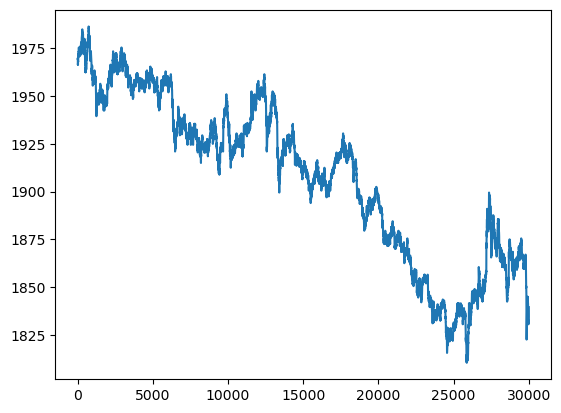

In [38]:
plt.plot(ink_data['mid_price'])

In [30]:
ink_data['Rt']=(ink_data['mid_price']-ink_data['mid_price'].shift(1))/ink_data['mid_price'].shift(1)

In [31]:
import pandas as pd
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox
returns = ink_data['Rt'].dropna()

# Fit GARCH(3,2) model (p=3 ARCH terms, q=2 GARCH terms)
model = arch_model(returns, vol='GARCH', p=3, q=2, mean='Constant')
results = model.fit(update_freq=5, disp='off')  # Suppress optimization output

# Print model summary (includes AIC, BIC, coefficients, etc.)
print(results.summary())

# Extract standardized residuals
std_residuals = results.resid / results.conditional_volatility

# Ljung-Box test on squared residuals (to check for remaining ARCH effects)
lb_test = acorr_ljungbox(std_residuals ** 2, lags=[10], return_df=True)
print("\nLjung-Box Test on Squared Standardized Residuals:")
print(lb_test)

# Extract key fit statistics
print(f"\nAkaike Information Criterion (AIC): {results.aic:.2f}")
print(f"Bayesian Information Criterion (BIC): {results.bic:.2f}")


ValueError: first_obs and last_obs produce in an empty array.

In [27]:
forecasts = results.forecast(horizon=1, reindex=True)
plt.figure(figsize=(12, 6))
plt.plot(actual_rt.index, actual_rt, label='Actual Returns', color='blue')
plt.plot(predicted_rt.index, predicted_rt, label='One-Step Ahead Forecast', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Actual Returns vs One-Step Ahead Forecasted Returns')
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'actual_rt' is not defined

<Figure size 1200x600 with 0 Axes>

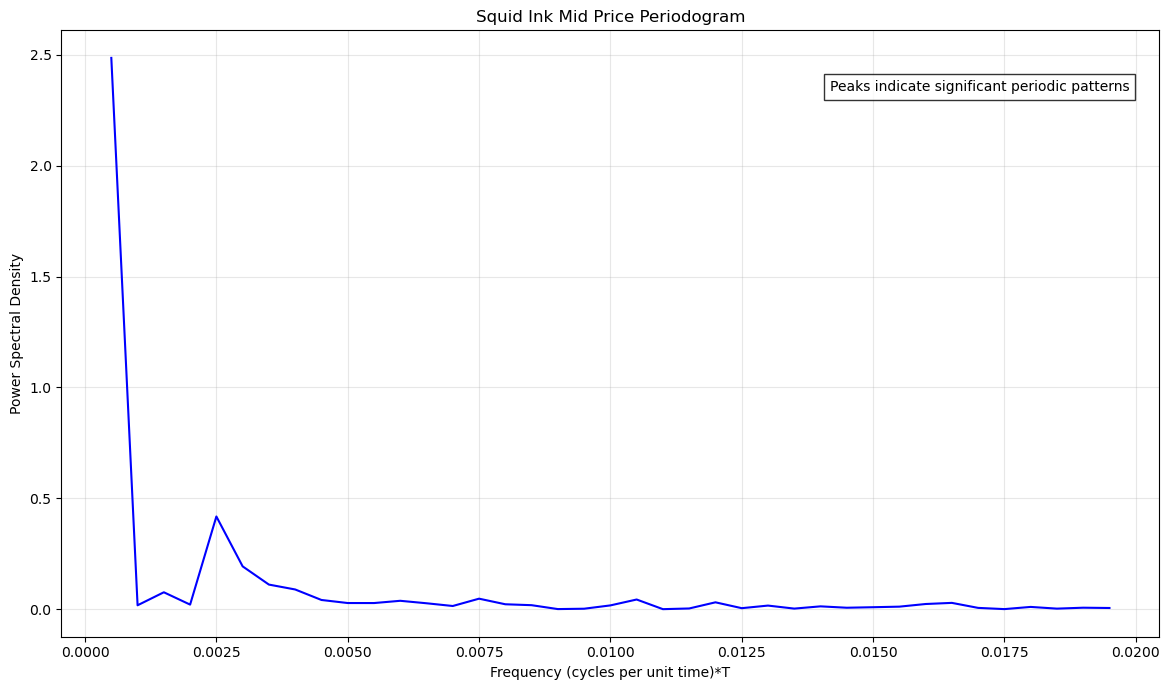

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming ink_data is a DataFrame with a 'mid_price' column
Xt = kelp_data['mid_price'][:2000].values
T = 2000

# Calculate frequencies
frequencies = np.arange(1, T) / T

# Calculate the scaled periodogram
P = []
for j in range(1, T//50):
    # Calculate a_j
    aj = 2 / T * np.sum(Xt * np.cos(2 * np.pi * np.arange(1, T + 1) * j / T))
    # Calculate b_j
    bj = 2 / T * np.sum(Xt * np.sin(2 * np.pi * np.arange(1, T + 1) * j / T))
    # Calculate P(j/T) = a_j^2 + b_j^2
    P.append(aj**2 + bj**2)

P = np.array(P)  # Convert to numpy array for plotting

# Plot the periodogram
plt.figure(figsize=(12, 7))
plt.plot(np.arange(1, T//50)/T, P, color='blue')
plt.title('Squid Ink Mid Price Periodogram')
plt.xlabel('Frequency (cycles per unit time)*T')
plt.ylabel('Power Spectral Density')
plt.grid(True, alpha=0.3)

# Optional: Add a legend explaining how to interpret the plot
plt.text(0.7, 0.9, 'Peaks indicate significant periodic patterns', 
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

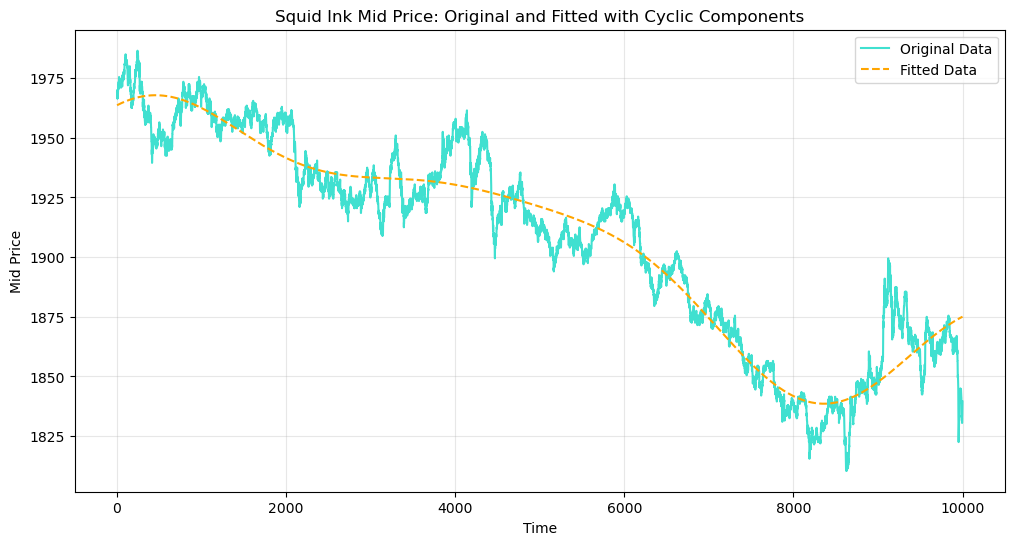

Fitted Amplitudes: [-20.21053779 -15.84686112  -5.39517599]
Fitted Phases: [-41.14877002  85.72424311  35.87994715]
Fitted Offset: 1952.1349841545982
Fitted Trend: -0.008860152846204273
Mean Squared Error: 126.539722


In [51]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Assuming ink_data is a DataFrame with mid_price column
# If you don't have ink_data defined yet, you'll need to load your data first
# For example: ink_data = pd.read_csv('your_data.csv')

# Extract time and price data
time = np.arange(len(ink_data['mid_price']))
mid_price = ink_data['mid_price'].values

# Define the model function with 3 cyclic components and a linear trend
def model_function(t, a1, a2, a3, phi1, phi2, phi3, offset, trend):
    return (a1 * np.sin(2 * np.pi * 0.0001 * t + phi1) +
            a2 * np.sin(2 * np.pi * 0.0002 * t + phi2) +
            a3 * np.sin(2 * np.pi * 0.0003 * t + phi3) + 
            offset + trend * t)  # Added linear trend to account for the clear trend

# Initial parameter guesses - adjust if needed for better convergence
initial_guess = [0.1, 0.1, 0.1, 0, 0, 0, 0, -0.002]  # amplitudes, phases, offset, trend

# Fit the model to the data with increased maxfev to avoid convergence errors
params, covariance = curve_fit(model_function, time, mid_price, 
                               p0=initial_guess, maxfev=10000)

# Extract fitted parameters
amplitudes = params[:3]
phases = params[3:6]
offset = params[6]
trend = params[7]

# Generate fitted data
fitted_mid_price = model_function(time, *params)

# Plot the original and fitted data
plt.figure(figsize=(12, 6))
plt.plot(time, mid_price, label='Original Data', color='turquoise')
plt.plot(time, fitted_mid_price, label='Fitted Data', linestyle='--', color='orange')
plt.xlabel('Time')
plt.ylabel('Mid Price')
plt.title('Squid Ink Mid Price: Original and Fitted with Cyclic Components')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print fitted parameters
print("Fitted Amplitudes:", amplitudes)
print("Fitted Phases:", phases)
print("Fitted Offset:", offset)
print("Fitted Trend:", trend)

# Calculate and print the mean squared error to evaluate fit quality
mse = np.mean((mid_price - fitted_mid_price) ** 2)
print(f"Mean Squared Error: {mse:.6f}")


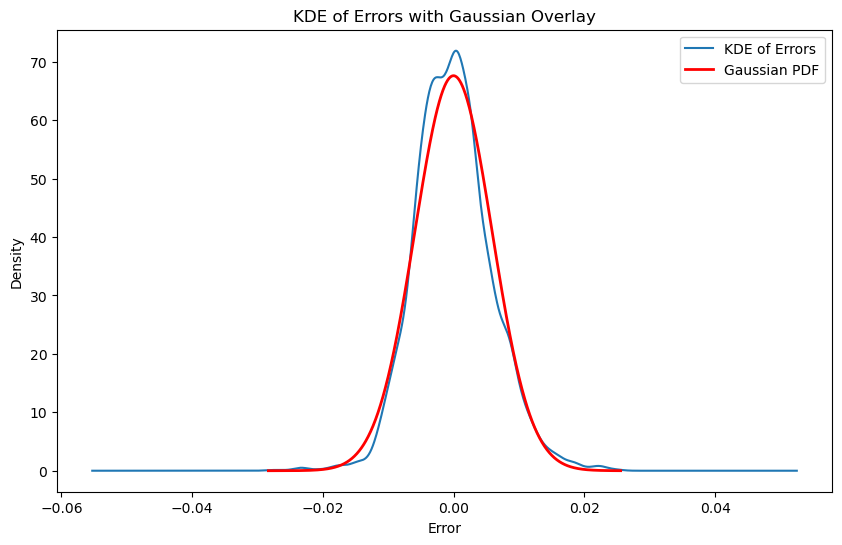

In [69]:
from scipy import stats

# Calculate errors (difference between actual and fitted prices)
errors = pd.Series((mid_price - fitted_mid_price)/mid_price)

# Plot KDE of errors
ax = errors.plot.kde(label='KDE of Errors', figsize=(10, 6))

# Calculate Gaussian PDF parameters
sample_mean = errors.mean()
sample_std = errors.std()

# Generate x values and compute Gaussian PDF
x = np.linspace(errors.min(), errors.max(), 1000)
pdf = stats.norm.pdf(x, loc=sample_mean, scale=sample_std)

# Overlay Gaussian PDF on the KDE plot
plt.plot(x, pdf, label='Gaussian PDF', color='red', linewidth=2)

# Add labels, title, and legend
plt.xlabel('Error')
plt.ylabel('Density')
plt.title('KDE of Errors with Gaussian Overlay')
plt.legend()
plt.show()

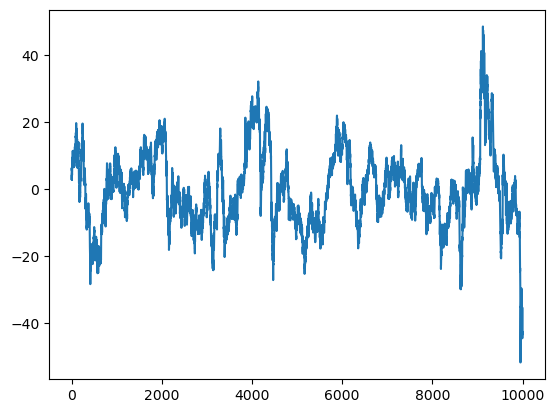

In [66]:
plt.plot(errors)

[ 8.40373104e-10     +0.j         -3.05964708e+04-237309.02984547j
  6.21717623e+04-119682.59031587j ...  2.61924205e+04 +53635.84111579j
  6.21717623e+04+119682.59031587j -3.05964708e+04+237309.02984547j]


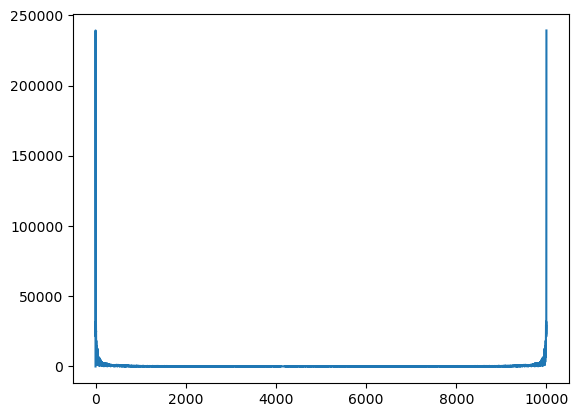

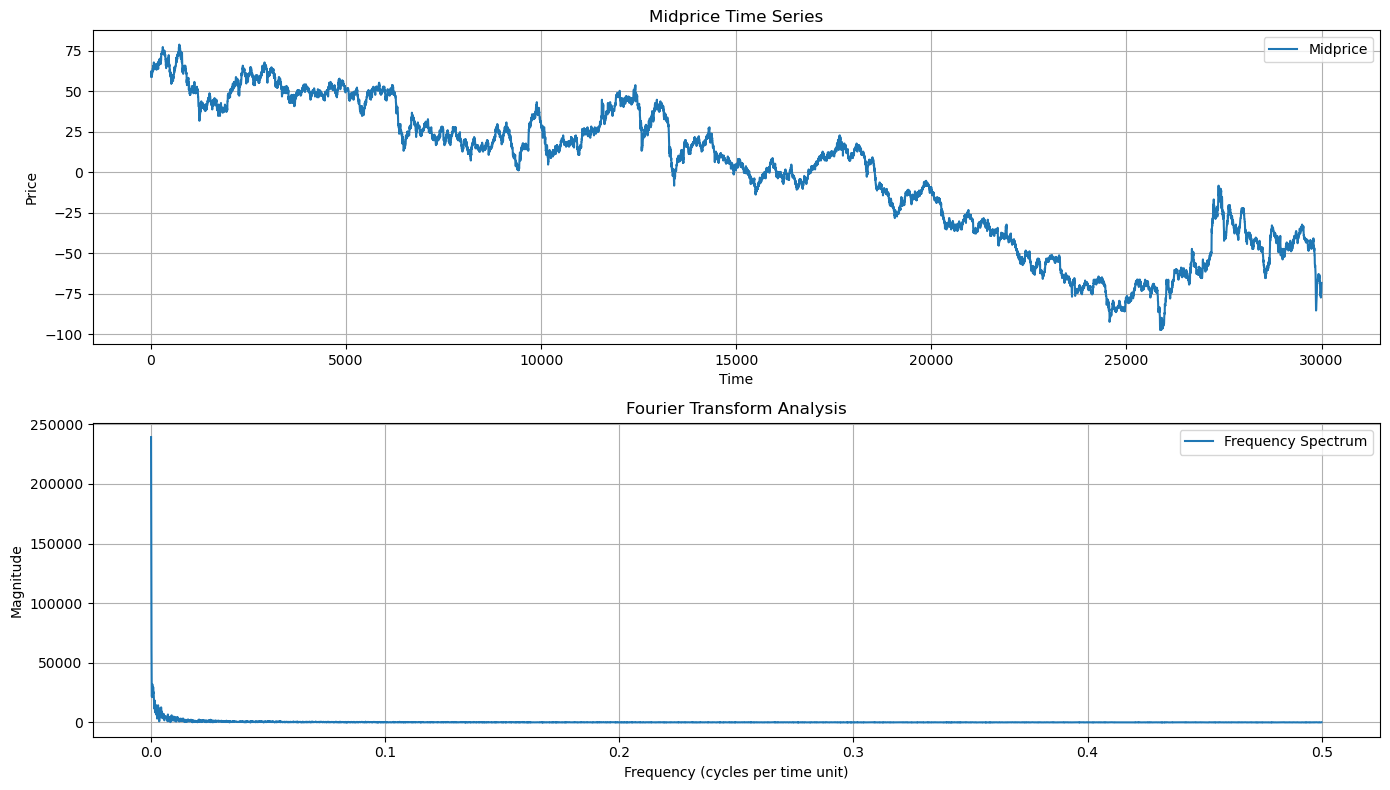

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Clean the data (remove NaNs if any)
midprice = ink_data['mid_price'].dropna()-np.mean(ink_data['mid_price'])

# Apply Fourier Transform
fft_result = np.fft.fft(midprice.values)
print(fft_result)
# Get frequencies and magnitudes
n = len(midprice)
freq = np.fft.fftfreq(n, d=1)  
magnitude = np.abs(fft_result)
plt.plot(magnitude)

# Plot results
plt.figure(figsize=(14, 8))

# Time domain plot
plt.subplot(2, 1, 1)
plt.plot(midprice.index, midprice, label='Midprice')
plt.title('Midprice Time Series')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.legend()

# Frequency domain plot
plt.subplot(2, 1, 2)
plt.plot(freq[1:n//2], magnitude[1:n//2], label='Frequency Spectrum')  # Only plot positive frequencies
plt.title('Fourier Transform Analysis')
plt.xlabel('Frequency (cycles per time unit)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
columns_to_plot = ['bid_volume_1', 'bid_volume_2', 'bid_volume_3',
                   'ask_volume_1', 'ask_volume_2', 'ask_volume_3']

num_plots = len(columns_to_plot)
num_rows = (num_plots + 1) // 2
num_cols = 2

plt.figure(figsize=(12, 4 * num_rows))

for i, column in enumerate(columns_to_plot, start=1):
    plt.subplot(num_rows, num_cols, i)
    
    volume_counts = ink_data[column].value_counts()
    
    plt.bar(volume_counts.index, volume_counts.values)
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column}')
    plt.xticks(rotation=45)
    plt.tight_layout(pad=3.0)

plt.show()

In [ ]:
def calculate_mm_mid(row):
    # Find the best bid with volume >= 20
    for i in range(1, 4):
        if row[f'bid_volume_{i}'] >= 1:
            best_bid = row[f'bid_price_{i}']
            break
    else:
        best_bid = None

    # Find the best ask with volume >= 20
    for i in range(1, 4):
        if row[f'ask_volume_{i}'] >= 1:
            best_ask = row[f'ask_price_{i}']
            break
    else:
        best_ask = None

    # Calculate the mid price if both best bid and ask are found
    if best_bid is not None and best_ask is not None:
        return (best_bid + best_ask) / 2
    else:
        return None
kelp_data['mm_mid']=kelp_data.apply(calculate_mm_mid, axis=1)
resin_data['mm_mid']=resin_data.apply(calculate_mm_mid, axis=1)
ink_data['mm_mid']=ink_data.apply(calculate_mm_mid, axis=1)
ink_data

In [ ]:
# Calculate Rt = (next_mid_price - current_mid_price) / current_mid_price
ink_data['Rt'] = (ink_data['mid_price'].shift(-1) - ink_data['mid_price']) / ink_data['mid_price']

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf  # Ensure this import is included

def plot_calculate_acf(column_data, lags=20):
    # Calculate ACF values
    acf_values = acf(column_data, nlags=lags, fft=False)
    
    # Create the ACF plot
    plt.figure(figsize=(10, 6))
    
    # Plot stems without deprecated `use_line_collection`
    plt.stem(range(len(acf_values)), acf_values, markerfmt='C0o', linefmt='C0-', basefmt="k-")
    
    plt.axhline(y=0, linestyle='--', color='gray')
    
    # Add confidence intervals
    conf_level = 1.96 / np.sqrt(len(column_data))
    plt.axhline(y=conf_level, linestyle=':', color='red', alpha=0.5)
    plt.axhline(y=-conf_level, linestyle=':', color='red', alpha=0.5)
    
    # Use the column's name from the pandas Series
    plt.title(f"Autocorrelation Function of {column_data.name}")
    plt.xlabel("Lag")
    plt.ylabel("ACF Value")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return acf_values

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import grangercausalitytests, adfuller, coint
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import pearsonr, spearmanr

# Sample data loading (replace with your actual data)
# ink_data = pd.DataFrame(...), kelp_data = pd.DataFrame(...), resin_data = pd.DataFrame(...)

# Create combined DataFrame
combined = pd.DataFrame({
    'ink': np.array(ink_data['mid_price']),
    'kelp': np.array(kelp_data['mid_price']),
    'resin': np.array(resin_data['mid_price'])
}).dropna()
combined

In [ ]:
def linear_regression(X, y):
    X_bias = np.c_[np.ones((X.shape[0], 1)), X]
    theta = np.linalg.inv(X_bias.T.dot(X_bias)).dot(X_bias.T).dot(y)
    y_pred = X_bias.dot(theta)
    y_mean = np.mean(y)
    ss_total = np.sum((y - y_mean) ** 2)
    ss_residual = np.sum((y - y_pred) ** 2)
    r_squared = 1 - (ss_residual / ss_total)
    
    return theta, r_squared

# Get clean, aligned data
X_clean = ink_data['mm_mid'].shift(1).iloc[1:]   # Drops first row (NaN)
y_clean = ink_data['mm_mid'].iloc[1:]            # Drops first row (original)

# Now X_clean and y_clean have no NaNs and are aligned
theta, r_squared = linear_regression(X_clean, y_clean)
print(theta)
print(r_squared)
plt.plot(theta[0]*ink_data['mm_mid'].shift(1)[1:]+theta[1])
plt.plot(ink_data['mm_mid'])

In [ ]:
def implement_arima_for_ink_data(ink_data):
    """
    Implement ARIMA model for the SQUID_INK mid_price time series data
    
    Parameters:
    -----------
    ink_data : DataFrame
        DataFrame containing SQUID_INK data with mid_price column
    """
    # Check if mid_price column exists
    if 'mid_price' not in ink_data.columns:
        raise ValueError("mid_price column not found in ink_data DataFrame")
    
    # Sort by day and timestamp to ensure proper time series order
    ink_data = ink_data.sort_values(by=['day', 'timestamp']).reset_index(drop=True)
    
    # Extract mid_price as time series
    ts = ink_data['mid_price']
    
    print(f"Number of observations in time series: {len(ts)}")
    
    # Check for stationarity using Augmented Dickey-Fuller test
    print("\nTesting for stationarity...")
    adf_result = adfuller(ts.dropna())
    print(f'ADF Statistic: {adf_result[0]:.4f}')
    print(f'p-value: {adf_result[1]:.4f}')
    print(f'Critical Values:')
    for key, value in adf_result[4].items():
        print(f'\t{key}: {value:.4f}')
    
    # Automatically find optimal parameters
    print("\nFinding optimal ARIMA parameters...")
    auto_model = auto_arima(ts, 
                           seasonal=False, 
                           trace=True,
                           suppress_warnings=True,
                           stepwise=True,
                           error_action="ignore",
                           max_p=5, max_d=2, max_q=5)
    
    print(f"\nBest ARIMA model: {auto_model.order}")
    p, d, q = auto_model.order
    
    # Fit ARIMA model
    print("\nFitting ARIMA model...")
    model = ARIMA(ts, order=(p, d, q))
    model_fit = model.fit()
    print(model_fit.summary())
    
    # Plot diagnostics
    print("\nPlotting diagnostics...")
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    model_fit.plot_diagnostics(fig=fig)
    plt.tight_layout()
    
    # Forecast future values (next 10 time steps)
    forecast_steps = 10
    
    # Get forecast with proper confidence intervals
    forecast_result = model_fit.get_forecast(steps=forecast_steps)
    forecast = forecast_result.predicted_mean
    forecast_ci = forecast_result.conf_int()
    
    # Plot the original series and forecasts
    plt.figure(figsize=(12, 6))
    plt.plot(ts, label='Observed')
    
    forecast_index = range(len(ts), len(ts) + forecast_steps)
    plt.plot(forecast_index, forecast, color='red', label='Forecast')
    
    # Plot confidence intervals correctly
    plt.fill_between(forecast_index,
                    forecast_ci.iloc[:, 0],  # Lower bound
                    forecast_ci.iloc[:, 1],  # Upper bound
                    color='pink', alpha=0.3, label='95% Confidence Interval')
    
    plt.title('SQUID_INK Mid Price: ARIMA Forecast')
    plt.xlabel('Time Step')
    plt.ylabel('Mid Price')
    plt.legend()
    plt.grid(True)
    
    # Calculate metrics
    residuals = model_fit.resid[~np.isnan(model_fit.resid)]
    mse = np.mean(residuals**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(residuals))
    
    print(f"\nModel Performance Metrics:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    
    return model_fit, forecast

In [ ]:
model_fit, forecast = implement_arima_for_ink_data(ink_data)


In [ ]:
forecast